In [1]:
from pykalman import KalmanFilter,UnscentedKalmanFilter
import scvelo as scv
import pandas as pd 
import numpy as np
from anndata import AnnData
import loompy
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import matplotlib.patches as mpatches
import pickle
import os
import mnnpy
import leidenalg
from sknetwork.clustering import Louvain, BiLouvain, modularity, bimodularity
from sknetwork.visualization import svg_graph, svg_digraph, svg_bigraph
# from sknetwork import path
from scipy import sparse
from IPython.display import SVG
import community
import gseapy as gp
import scanpy as sc
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from scipy.stats import norm as normal
import networkx as nx
from scipy import stats,signal
from tslearn.preprocessing import TimeSeriesResampler
from sklearn.cross_decomposition import PLSRegression
from sklearn import linear_model
from sklearn.feature_selection import VarianceThreshold
from scipy.sparse import csr_matrix
from sklearn.manifold import MDS,TSNE,SpectralEmbedding,Isomap,smacof
import seaborn as sns
from scipy.sparse.csgraph import csgraph_from_dense
from networkx.algorithms import centrality
from networkx.algorithms import cluster
from IPython.core.display import display, SVG
import leidenalg
import igraph
import louvain
from collections import defaultdict
from networkx_community_layout import community_layout
import random
from sklearn.utils.class_weight import compute_class_weight
from matplotlib.pyplot import figure, text


In [2]:
dim_n=10

data_path='C:/Users/zoro/Desktop/Frustration_paper/data_analysis/data/'
main_path='C:/Users/zoro/Desktop/Frustration_paper/data_analysis/'
result_path='result/'
adata=scv.read(result_path+'EG_dyn.h5ad')
rc_extend=np.load(result_path+'EG_rc_extend.npy')

path=np.load(result_path+'EG_dyn_rc.npy')
gene_arr=np.load(result_path+'EG_bin_genes.npy',allow_pickle=True)


In [3]:
F_sparse=np.load(result_path+'sparse_EG_F.npy')

In [4]:
gene_arr=np.load(result_path+'EG_bin_genes.npy',allow_pickle=True)
gene_center=np.load(result_path+'EG_bin_genes_center.npy')

In [5]:
V0_ori=adata.layers['velocity_S'].A
X0_ori=adata.layers['M_s'].A

In [6]:
bin_centers=np.load(result_path+'EG_bin_genes_center.npy',allow_pickle=True)
# print(bin_centers)
X0_bin=X0_ori.copy()
for i in range(X0_ori.shape[1]):
    gene_kc=bin_centers[i,:]
    x=X0_ori[:,i]
    x_dist0=abs(x-gene_kc[0])
    x_dist1=abs(x-gene_kc[1])
#     print(x_dist0)
    
#     print(x_dist0<x_dist1)
    
    X0_bin[:,i][x_dist0<x_dist1]=0
    X0_bin[:,i][x_dist0>=x_dist1]=1

In [7]:
X0_bin[np.where(X0_bin==0)]=-1
X0_bin.shape

(1731, 470)

In [8]:
X0=StandardScaler().fit_transform(adata.layers['M_s'].A)
V0=StandardScaler().fit_transform(adata.layers['velocity_S'].A)
gene_list=adata.var.index.values
V0.shape

(1731, 470)

In [9]:
data_rc=np.array([np.argmin(np.linalg.norm((adata.obsm['X_pca'][i,:dim_n]-rc_extend),axis=1)) for i in range(adata.shape[0])])
np.unique(data_rc,return_counts=True)

path_neigh=[[] for i in range(rc_extend.shape[0])]
for i in range(rc_extend.shape[0]):
#     mask=np.in1d(np.argsort(np.linalg.norm((adata.obsm['X_pca'][:,:dim_n]-path[i,:]),axis=1))[:200],np.where(data_rc==i)[0])
#     path_neigh[i]=np.argsort(np.linalg.norm((adata.obsm['X_pca'][:,:dim_n]-path[i,:]),axis=1))[:200][mask][:100].tolist()
#     print(len(path_neigh[i]))
    mask=np.in1d(np.where(data_rc==i)[0],np.argsort(np.linalg.norm((adata.obsm['X_pca'][:,:dim_n]-rc_extend[i,:]),axis=1))[:200])
    path_neigh[i]=np.where(data_rc==i)[0][mask].tolist()
    print(len(path_neigh[i]))

7
119
50
52
56
66
104
137
89
84
82
92
116
80
96
164
71


In [35]:
F=csr_matrix((F_sparse[:,2], (F_sparse[:,0], F_sparse[:,1])), shape=(V0.shape[1],V0.shape[1])).toarray()
# F=np.load(result_path+'grisli_EG_F.npy')
G= igraph.Graph.Weighted_Adjacency(F.tolist())

res_v=0.8
partition=leidenalg.find_partition(G, leidenalg.RBConfigurationVertexPartition,resolution_parameter=res_v)
# partition=louvain.find_partition(G, louvain.ModularityVertexPartition)


In [36]:
print(partition)

Clustering with 470 elements and 31 clusters
[ 0] 3, 5, 6, 7, 8, 11, 12, 14, 30, 31, 35, 36, 38, 39, 40, 45, 48, 50, 52,
     55, 58, 60, 62, 66, 67, 73, 74, 84, 85, 89, 91, 92, 94, 100, 101, 103,
     109, 110, 111, 116, 118, 119, 120, 124, 125, 127, 128, 138, 144, 146,
     148, 149, 163, 164, 165, 169, 170, 171, 178, 179, 181, 182, 183, 184,
     185, 187, 188, 190, 191, 193, 196, 197, 198, 199, 204, 205, 208, 209,
     215, 221, 222, 226, 228, 229, 234, 236, 239, 240, 242, 244, 252, 253,
     256, 264, 268, 270, 280, 288, 290, 291, 292, 294, 299, 305, 308, 313,
     318, 319, 324, 325, 328, 331, 334, 336, 337, 339, 341, 344, 350, 351,
     353, 354, 355, 359, 361, 364, 365, 384, 393, 395, 401, 404, 411, 416,
     418, 419, 424, 425, 426, 431, 433, 435, 437, 440, 442, 443, 448, 450,
     451, 452, 453, 455, 456, 457, 459, 460, 462, 465, 466, 467, 468
[ 1] 2, 4, 9, 15, 16, 20, 24, 25, 26, 28, 29, 32, 33, 47, 49, 51, 53, 54, 61,
     69, 70, 71, 77, 78, 79, 80, 81, 82, 83, 86, 87, 93,

In [48]:
# for i in range(4,len(partition)):
#     for j in partition[i]:
#         print(np.where(F[j,:]),np.where(F[:,j]))

In [22]:
partition_label=np.zeros(F.shape[0],)
for i in range(len(partition)):
    for j in partition[i]:
        partition_label[j]=i

In [23]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
#     array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

In [24]:
def _find_between_community_edges(g, partition):
    
    inter_com_count=0
    edges = dict()
    edge_list = [edge.tuple for edge in g.es]
    for (ni, nj) in edge_list:
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            inter_com_count+=1
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges,inter_com_count

In [25]:
inter_edges,G_inter_counts=_find_between_community_edges(G,partition_label)
print(G_inter_counts)

1837


In [26]:
lgc=[]
cc_num=[]
part_num=[]
gini_index=[]
mean_edge_weight=[]
edge_density=[]
inter_counts=[]
intra_counts=[]
ON_gene=[]
sub_intra_counts=np.zeros((X0_bin.shape[0],3))
sub_ON_gene=np.zeros((X0_bin.shape[0],3))
for i in range(X0_bin.shape[0]):
    F_sign=(np.sign((X0_bin[i,:]>0).astype(np.int)*((F*X0_bin[i,:]).T))).T
    F_eff=np.multiply(F_sign,F)
    G_eff=igraph.Graph.Weighted_Adjacency(F_eff.tolist())
    for p_ind in [0,1,2]:
        sub_F_eff=F_eff[partition[p_ind],:][:,partition[p_ind]]
        sub_intra_counts[i,p_ind]=np.count_nonzero(sub_F_eff)
        sub_ON_gene[i,p_ind]=np.where(X0_bin[i,partition[p_ind]]>0)[0].shape[0]
# #     part_eff=leidenalg.find_partition(G_eff, leidenalg.RBConfigurationVertexPartition,resolution_parameter=1)
# #     partition_label=np.zeros(F.shape[0],)
# #     for i in range(len(part_eff)):
# #         for j in part_eff[i]:
# #             partition_label[j]=i
    _,counts=_find_between_community_edges(G_eff,partition_label)
    inter_counts.append(counts)
    intra_counts.append(np.count_nonzero(F_eff)-counts)
    
    ON_gene.append(np.where(X0_bin[i,:]>0)[0].shape[0])
    gini_index.append(gini(np.array(G_eff.degree())))
    mean_edge_weight.append(np.mean(abs(F_eff[F_eff!=0])))
    gcc=np.amax(np.array(G_eff.components(mode='weak').sizes()))
    
    gcc_ind=np.argmax(np.array(G_eff.components(mode='weak').sizes()))
#     gcc_cat=gene_cat[np.array(G_eff.components(mode='weak'))[gcc_ind]]
#     gcc_weighted=(gcc_cat.shape[0]-np.sum(gcc_cat))*gene_weight[0]+np.sum(gcc_cat)*gene_weight[1]
    
    part_num.append(len(leidenalg.find_partition(G_eff, leidenalg.RBConfigurationVertexPartition,resolution_parameter=1)))
    lgc.append(gcc)
    cc_num.append(len(np.array(G_eff.components(mode='weak').sizes())))
    edge_density.append(G_eff.density())

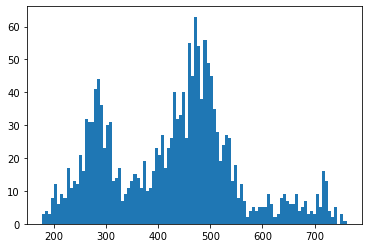

[[1.         0.97386448]
 [0.97386448 1.        ]]


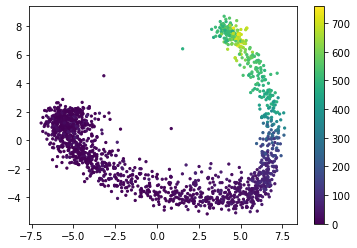

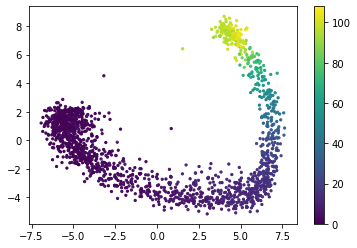

[[1.         0.98619088]
 [0.98619088 1.        ]]


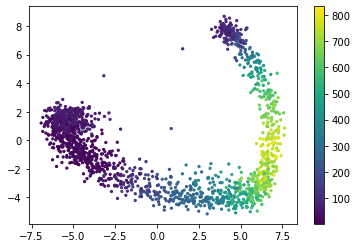

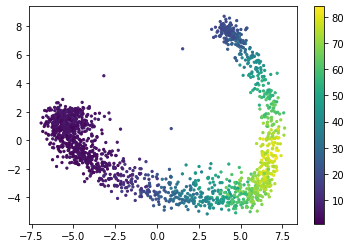

[[1.         0.99652513]
 [0.99652513 1.        ]]


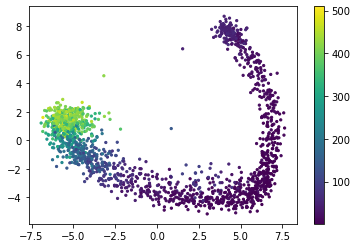

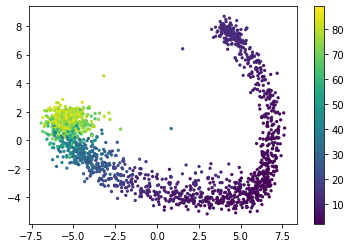

In [49]:
plt.hist(inter_counts,bins=100)
plt.show()
for p_ind in [0,1,2]:
    print(np.corrcoef(sub_intra_counts[:,p_ind],sub_ON_gene[:,p_ind]))
    adata.obs['sub_intra']=sub_intra_counts[:,p_ind]
    # scv.pl.scatter(adata, basis='pca',color='part_num')
    plt.scatter(adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1],s=5,c=sub_intra_counts[:,p_ind],cmap=plt.cm.viridis)
    plt.colorbar()
    plt.show()
    
    adata.obs['sub_ON']=sub_ON_gene[:,p_ind]
    # scv.pl.scatter(adata, basis='pca',color='part_num')
    plt.scatter(adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1],s=5,c=sub_ON_gene[:,p_ind],cmap=plt.cm.viridis)
    plt.colorbar()
    plt.show()

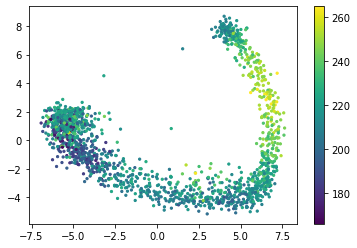

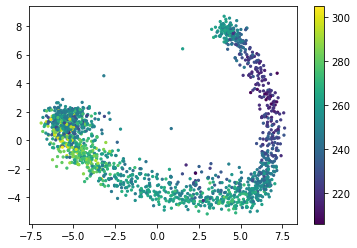

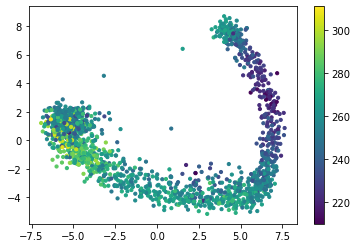

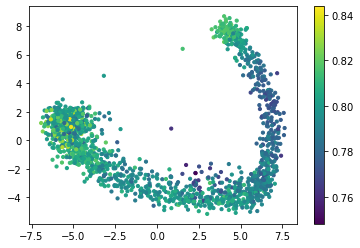

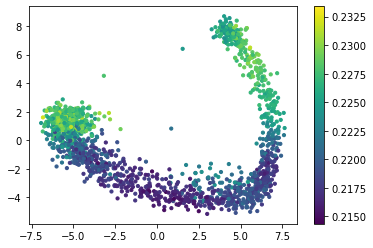

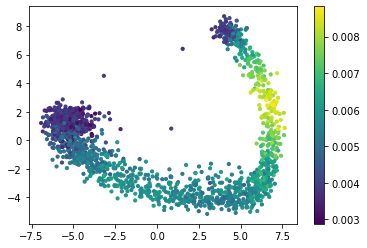

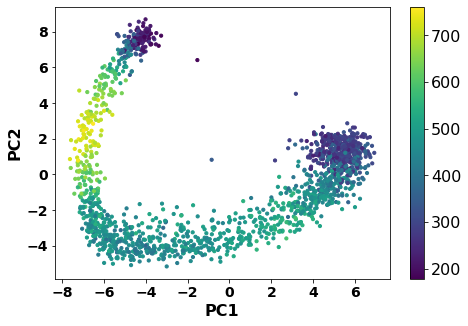

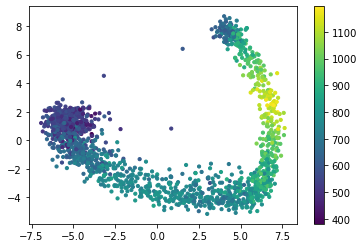

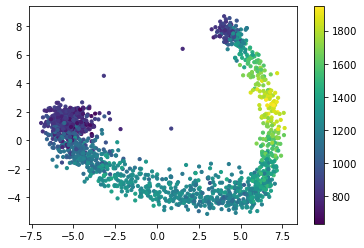

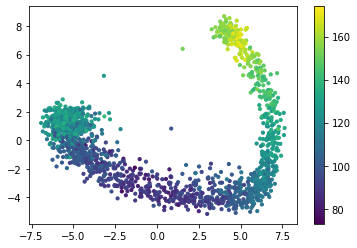

In [28]:
adata.obs['lgc']=lgc
adata.obs['cc_num']=cc_num
adata.obs['part_num']=part_num
adata.obs['gini_index']=gini_index
adata.obs['mean_edge_weight']=mean_edge_weight
adata.obs['edge_density']=edge_density
adata.obs['inter_com']=inter_counts
adata.obs['intra_com']=intra_counts
adata.obs['ON_gene']=ON_gene
# scv.pl.scatter(adata, basis='pca',color='part_num')
plt.scatter(adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1],s=5,c=lgc,cmap=plt.cm.viridis)
plt.colorbar()
plt.show()

plt.scatter(adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1],s=5,c=cc_num,cmap=plt.cm.viridis)
plt.colorbar()
plt.show()

plt.scatter(adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1],s=10,c=part_num,cmap=plt.cm.viridis)
plt.colorbar()
plt.show()
plt.scatter(adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1],s=10,c=gini_index,cmap=plt.cm.viridis)
plt.colorbar()
plt.show()

plt.scatter(adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1],s=10,c=mean_edge_weight,cmap=plt.cm.viridis)
plt.colorbar()
plt.show()

plt.scatter(adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1],s=10,c=edge_density,cmap=plt.cm.viridis)
plt.colorbar()
plt.show()

fig,ax=plt.subplots(figsize=(7.5,5))
plt.scatter(-adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1],s=10,c=inter_counts,cmap=plt.cm.viridis)
plt.xticks(fontsize=14,fontweight='bold')
plt.yticks(fontsize=14,fontweight='bold')  
plt.xlabel('PC1',fontsize=16,fontweight='bold')
plt.ylabel('PC2',fontsize=16,fontweight='bold')
cb=plt.colorbar()
cb.ax.tick_params(labelsize=16)
plt.savefig(result_path+'EG_inter_com_counts_'+str(res_v)+'.png',dpi=300)
plt.show()

plt.scatter(adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1],s=10,c=intra_counts,cmap=plt.cm.viridis)
plt.colorbar()
plt.show()

plt.scatter(adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1],s=10,c=np.array(intra_counts)+np.array(inter_counts),cmap=plt.cm.viridis)
plt.colorbar()
plt.show()

plt.scatter(adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1],s=10,c=ON_gene,cmap=plt.cm.viridis)
plt.colorbar()
plt.show()

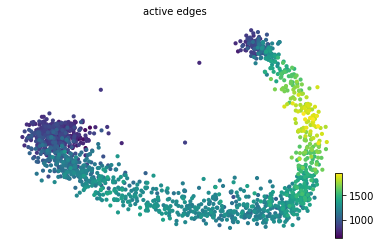

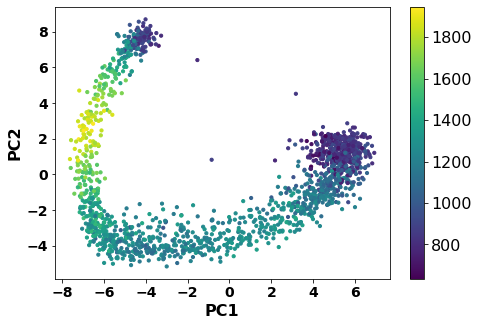

In [24]:
def eff_edges(X1,X2,F):
    F_sign=(np.sign((X1>0).astype(np.int)*((F*X2).T))).T
    edge_num=np.where(F_sign)[0].shape[0]
    return edge_num

eff_edge_count=[]
for i in range(X0_bin.shape[0]):
    eff_edge_count.append(eff_edges(X0_bin[i,:],X0_bin[i,:],F))
adata.obs['active edges']=eff_edge_count
scv.pl.scatter(adata, basis='pca',color='active edges')


fig,ax=plt.subplots(figsize=(7.5,5))
plt.scatter(-adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1],s=10,c=eff_edge_count,cmap=plt.cm.viridis)


plt.xticks(fontsize=14,fontweight='bold')
plt.yticks(fontsize=14,fontweight='bold')  
plt.xlabel('PC1',fontsize=16,fontweight='bold')
plt.ylabel('PC2',fontsize=16,fontweight='bold')
cb=plt.colorbar()
cb.ax.tick_params(labelsize=16)
plt.savefig(result_path+'EG_active_edge.png',dpi=300)
plt.show()

In [25]:
np.corrcoef(np.array(eff_edge_count),np.array(inter_counts))

array([[1.        , 0.95194088],
       [0.95194088, 1.        ]])

In [26]:
np.corrcoef(np.array(ON_gene),np.array(inter_counts))

array([[1.        , 0.07429912],
       [0.07429912, 1.        ]])

In [27]:
#-----------resilence-----------------------

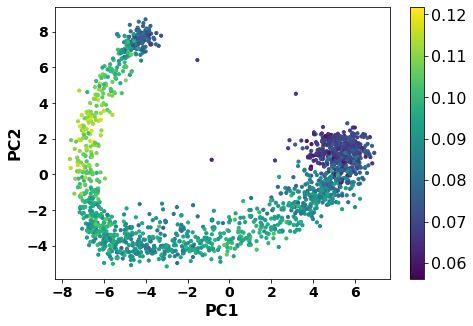

In [28]:
def degree_hetero(F):
    arr=np.array([np.count_nonzero(F[i,:])+np.count_nonzero(F[:,i]) for i in range(F.shape[0])])
    uni_k,counts=np.unique(arr,return_counts=True)
    pk=counts/np.sum(counts)
    deg_h=np.sum((1-pk)**2)/F.shape[0]
    return deg_h

deg_h=[]
for i in range(X0_bin.shape[0]):
    F_sign=(np.sign((X0_bin[i,:]>0).astype(np.int)*((F*X0_bin[i,:]).T))).T
    F_eff=np.multiply(F_sign,F)
    
    deg_h.append(degree_hetero(F_eff))
    
adata.obs['deg_h']=deg_h
# scv.pl.scatter(adata, basis='pca',color='part_num')
fig,ax=plt.subplots(figsize=(7.5,5))
plt.scatter(-adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1],s=10,c=deg_h,cmap=plt.cm.viridis)
plt.xticks(fontsize=14,fontweight='bold')
plt.yticks(fontsize=14,fontweight='bold')  
plt.xlabel('PC1',fontsize=16,fontweight='bold')
plt.ylabel('PC2',fontsize=16,fontweight='bold')
cb=plt.colorbar()
cb.ax.tick_params(labelsize=16)
plt.savefig(result_path+'EG_degree_hetero.png',dpi=300)
plt.show()

In [29]:
def Resilence(F,X):

    s_out=[np.count_nonzero(F[i,:]) for i in range(F.shape[0])]#/(np.count_nonzero(F[i,:])+np.count_nonzero(F[:,i])+1e-6)
    s_in=[np.count_nonzero(F[:,i]) for i in range(F.shape[1])]
    
#     _,out_counts=np.unique(np.array(s_out),return_counts=True)

#     sigma_P_out=np.std(out_counts/np.sum(out_counts))
    
#     _,in_counts=np.unique(np.array(s_in),return_counts=True)

#     sigma_P_in=np.std(in_counts/np.sum(in_counts))
    
    
    sigma_P_in=np.std(np.array(s_in))
    
    sigma_P_out=np.std(np.array(s_out))
    
#     print(sigma_P_in,sigma_P_out)
    
    mean_in=np.mean(np.array(s_in))
    mean_out=np.mean(np.array(s_out))
#     print(mean_in,mean_out)
    mean_degree=np.mean(np.array([np.count_nonzero(F[i,:])+np.count_nonzero(F[:,i]) for i in range(F.shape[0])]))
#     print(mean_degree)
    S=(np.mean(np.array([np.count_nonzero(F[i,:])*np.count_nonzero(F[:,i]) for i in range(F.shape[0])]))-mean_in*mean_out)/sigma_P_in/sigma_P_out
    
    H=sigma_P_in*sigma_P_out/mean_degree
    return mean_degree,H,S

In [30]:
hetero=[]
md=[]
symm=[]
for i in range(X0_bin.shape[0]):
    F_sign=(np.sign((X0_bin[i,:]>0).astype(np.int)*((F*X0_bin[i,:]).T))).T
    F_eff=np.multiply(F_sign,F)
    
    mean_d,h,s=Resilence(F_sign,X0_bin[i,:])
#     print(h,mean_d)
    hetero.append(h)
    md.append(mean_d)#/np.where(X0_bin[i,:]>0)[0].shape[0]
    symm.append(s)
hetero=np.array(hetero)

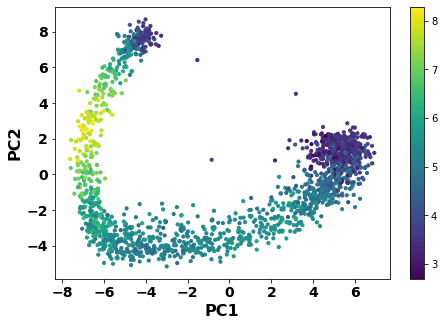

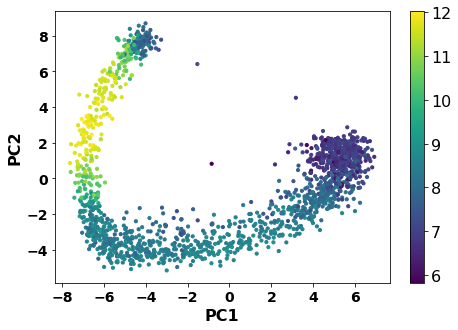

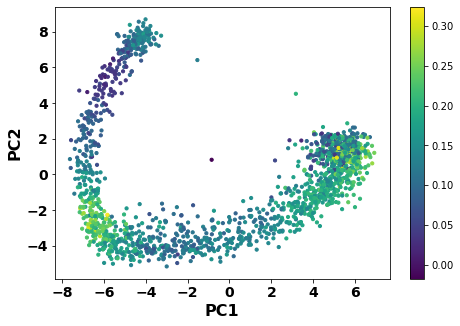

In [31]:
adata.obs['Heterogeneity']=hetero
adata.obs['md']=md
adata.obs['symm']=symm
# scv.pl.scatter(adata, basis='pca',color='part_num')
fig,ax=plt.subplots(figsize=(7.5,5))
plt.scatter(-adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1],s=10,c=md,cmap=plt.cm.viridis)
plt.xticks(fontsize=14,fontweight='bold')
plt.yticks(fontsize=14,fontweight='bold')  
plt.xlabel('PC1',fontsize=16,fontweight='bold')
plt.ylabel('PC2',fontsize=16,fontweight='bold')
plt.colorbar()
# plt.savefig(result_path+'emt_edge_density.png',dpi=300)
plt.show()

fig,ax=plt.subplots(figsize=(7.5,5))
plt.scatter(-adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1],s=10,c=hetero,cmap=plt.cm.viridis)
plt.xticks(fontsize=14,fontweight='bold')
plt.yticks(fontsize=14,fontweight='bold')  
plt.xlabel('PC1',fontsize=16,fontweight='bold')
plt.ylabel('PC2',fontsize=16,fontweight='bold')
cb=plt.colorbar()
cb.ax.tick_params(labelsize=16)
plt.savefig(result_path+'EG_hetero.png',dpi=300)
plt.show()

fig,ax=plt.subplots(figsize=(7.5,5))
plt.scatter(-adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1],s=10,c=symm,cmap=plt.cm.viridis)
plt.xticks(fontsize=14,fontweight='bold')
plt.yticks(fontsize=14,fontweight='bold')  
plt.xlabel('PC1',fontsize=16,fontweight='bold')
plt.ylabel('PC2',fontsize=16,fontweight='bold')
plt.colorbar()
# plt.savefig(result_path+'emt_symmetry.png',dpi=300)
plt.show()

In [32]:
'------------------------------------------------------'

'------------------------------------------------------'

In [33]:
if not os.path.exists(result_path+'EG_res_'+str(res_v)+'/'):
    os.mkdir(result_path+'EG_res_'+str(res_v)+'/')
com_path=result_path+'EG_res_'+str(res_v)+'/'

In [34]:
partition_label=np.zeros(F.shape[0],)
for i in range(len(partition)):
    for j in partition[i]:
        partition_label[j]=i

In [35]:
def _find_between_community_edges(g, partition):
    
    inter_com_count=0
    edges = dict()
    edge_list = [edge.tuple for edge in g.es]
    for (ni, nj) in edge_list:
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            inter_com_count+=1
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges,inter_com_count

def find_inter_commu(g, com_a,com_b,partition_label):
    
    ab_com_count=0
    edge_list = [edge.tuple for edge in g.es]
    for (ni, nj) in edge_list:
        ci = partition_label[ni]
        cj = partition_label[nj]

        if ci==com_a and cj==com_b:
            ab_com_count+=1
#         if ci==com_b and cj==com_a:
#             ba_com_count+=1
        
            


    return ab_com_count

In [36]:
inter_edges,inter_com_counts=_find_between_community_edges(G,partition_label)
# print(inter_edges[(1.0, 0.0)])

com_G=nx.DiGraph()
for i in range(len(partition)):
    for j in range(len(partition)):
        if i!=j:
            if len(partition[i])>1 and len(partition[j])>1:
                print(i,j)
                ij_count=find_inter_commu(G, i,j,partition_label)
                com_G.add_edge(i,j,color='r',weight=ij_count)

com_inds=[]
com_size=[]
for i in range(len(partition)):
    if len(partition[i])>1:
        com_size.append(len(partition[i])*30)
        com_inds.append(i)

0 1
0 2
1 0
1 2
2 0
2 1


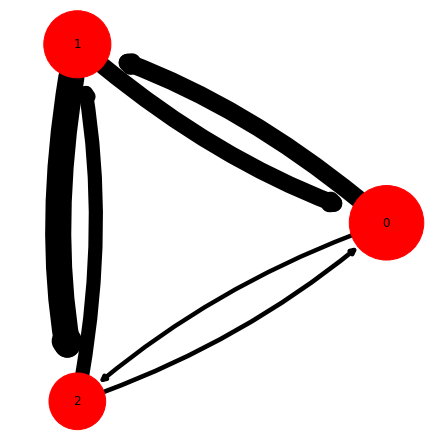

In [37]:
pos = nx.circular_layout(com_G,scale=1)
d = dict(com_G.degree)
weights = [com_G[u][v]['weight']/15 for u,v in com_G.edges()]
plt.figure(figsize=(6,6))

nx.draw(com_G,pos,node_size=com_size, node_color='red',with_labels = False, connectionstyle='arc3, rad = 0.1',width=weights)



for node, (x, y) in pos.items():
    text(x, y, node, fontsize=d[node]*3, ha='center', va='center')

plt.axis('equal')
plt.show()

1
(470,)
(1006,)
266 0.2644135188866799
1.6521739130434783


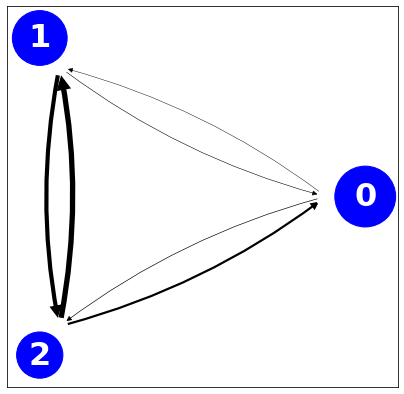

2
(470,)
(1373,)
442 0.3219227967953387
2.6


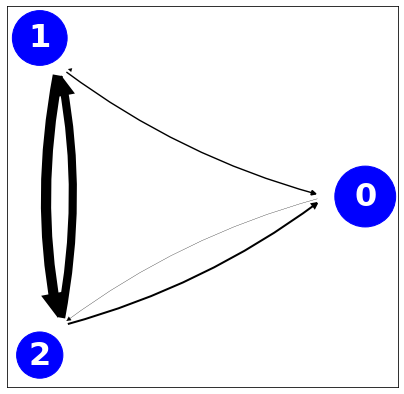

3
(470,)
(1674,)
555 0.33154121863799285
3.627450980392157


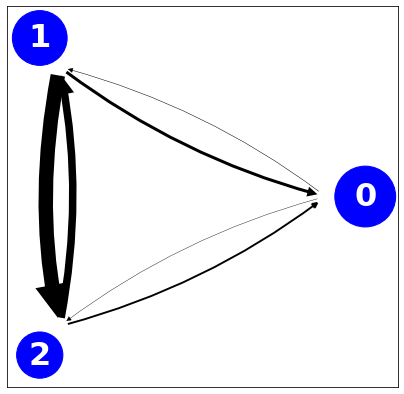

4
(470,)
(1901,)
613 0.32246186217780115
4.378571428571429


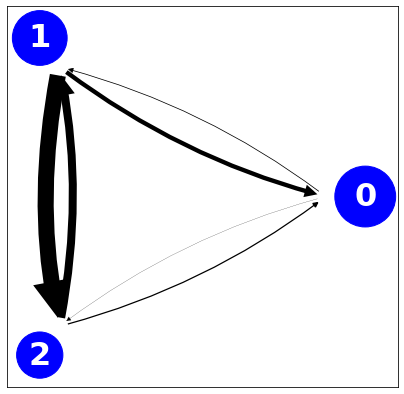

5
(470,)
(1731,)
504 0.29116117850953205
3.7058823529411766


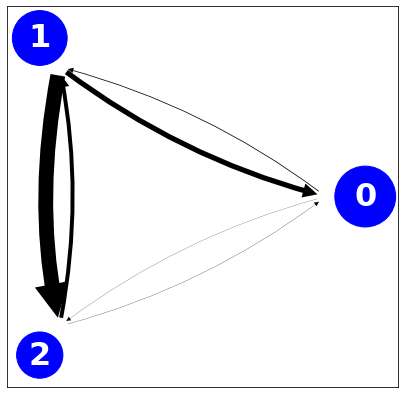

6
(470,)
(1319,)
325 0.24639878695981804
2.73109243697479


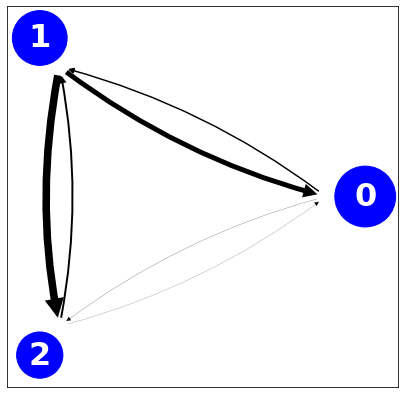

7
(470,)
(1364,)
359 0.2631964809384164
3.0948275862068964


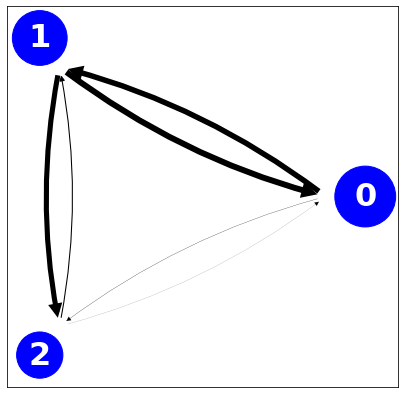

8
(470,)
(1165,)
323 0.2772532188841202
3.329896907216495


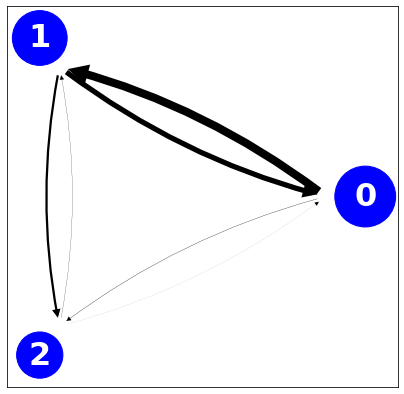

9
(470,)
(1228,)
334 0.2719869706840391
3.7954545454545454


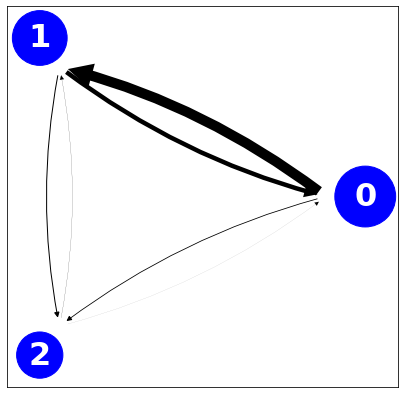

10
(470,)
(1266,)
352 0.27804107424960506
4.2926829268292686


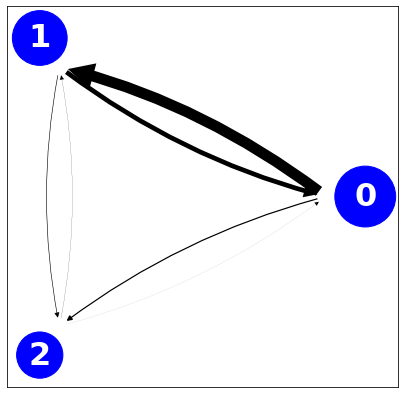

11
(470,)
(1290,)
293 0.22713178294573644
3.21978021978022


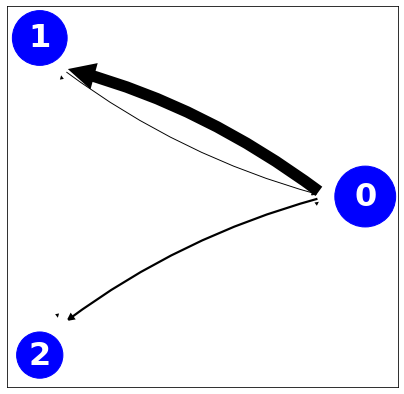

12
(470,)
(1191,)
225 0.1889168765743073
2.25


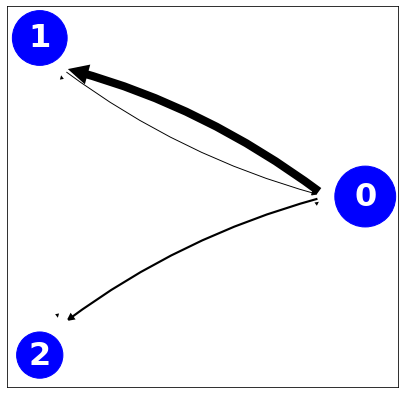

13
(470,)
(1038,)
168 0.16184971098265896
1.5


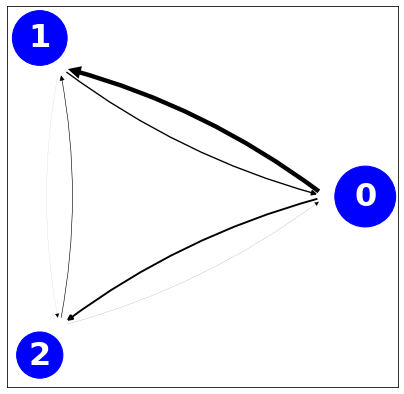

14
(470,)
(953,)
123 0.12906610703043023
0.8978102189781022


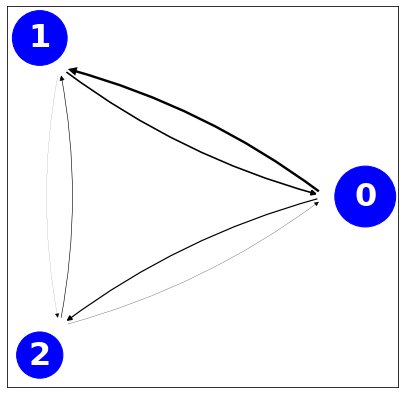

15
(470,)
(905,)
98 0.10828729281767956
0.7101449275362319


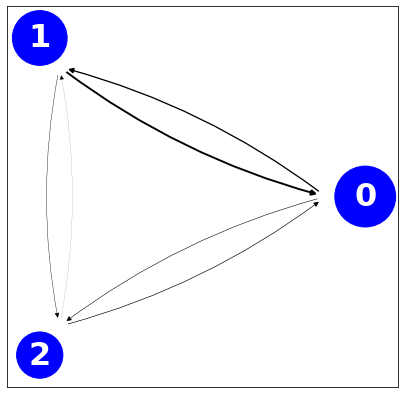

In [40]:
for ind in range(1,rc_extend.shape[0]-1):
    print(ind)
    Xm=np.mean(X0_ori[path_neigh[ind],:],axis=0)
    print(Xm.shape)


    low_dist=abs(Xm-gene_center[:,0])
    high_dist=abs(Xm-gene_center[:,1])
    Xm_bin=(high_dist<low_dist).astype(np.int)
    
    
    Xm_bin[Xm_bin==0]=-1
    F_sign=(np.sign((Xm_bin>0).astype(np.int)*((F*Xm_bin).T))).T
    F_eff=np.multiply(F_sign,F)
    G_eff=igraph.Graph.Weighted_Adjacency(F_eff.tolist())
    print(np.where(F_eff)[0].shape)
    inter_count=0

    com_G=nx.DiGraph()
#     c=0
    for i in range(len(partition)):
        for j in range(len(partition)):
            if i!=j:
                if len(partition[i])>1 and len(partition[j])>1:
                    ij_count=find_inter_commu(G_eff, i,j,partition_label)
                    inter_count+=ij_count
                    com_G.add_edge(i,j,weight=ij_count)
#                     com_G.add_edge(i,j,color='r',weight=np.mean(group_com_counts,axis=0)[c])
#     pos = nx.circular_layout(com_G)
    print(inter_count,inter_count/np.where(F_eff)[0].shape[0])
    print(inter_count/np.where(Xm_bin>0)[0].shape[0])
    d = dict(com_G.degree)
    edges = com_G.edges()
#     colors = [G[u][v]['color'] for u,v in edges]
    weights = [com_G[u][v]['weight']/20 for u,v in edges]
    plt.figure(figsize=(7,7))
        
#     nx.draw(com_G,pos,node_size=com_size, node_color='red',with_labels = False, \
#             connectionstyle='arc3, rad = 0.1',width=weights, edge_color = 'black',arrows=True)

    
    pos = nx.circular_layout(com_G,scale=0.9)
    arrows = nx.draw_networkx_edges(
    com_G,
    pos=pos,
    connectionstyle='arc3, rad = 0.1',
    arrows=True,
    width=weights,
    edge_color = 'black',
    arrowstyle='-|>'  )
    
    for a, w in zip(arrows, weights):
    
        # mutation_scale affects only the arrowhead size, not the arrow tail.
        # The constants here are arbitrary; you may want/need to change them
        a.set_mutation_scale(10 + w)

        # Sharpen arrowheads by creating a mitered joint between arrowhead 
        # line segments, instead of the default joinstyle='round'
        a.set_joinstyle('miter')

        # Prevent each arrow tail from jutting forward and through the arrowhead,
        # which happens with the default capstyle='projecting'
        a.set_capstyle('butt')

    
    
    pos = nx.circular_layout(com_G,scale=1.1)
    nodes = nx.draw_networkx_nodes(
    com_G,
    pos=pos,
    alpha=1,
    node_size=np.array(com_size)/1.5, node_color='blue')

    
    
    
    for node, (x, y) in pos.items():
        text(x, y, node, fontsize=d[node]*8, ha='center', va='center',color='white',fontweight='bold')
        
    x_values, y_values = zip(*pos.values())
    x_max = max(x_values)
    x_min = min(x_values)
    x_margin = (x_max - x_min) * 0.1
    
    
    y_max = max(y_values)
    y_min = min(y_values)
    y_margin = (y_max - y_min) * 0.1
    
    plt.xlim(x_min - x_margin, x_max + x_margin)
    plt.ylim(y_min - y_margin, y_max + y_margin)
        
    plt.savefig(com_path+'EG_rc'+str(ind)+'_commu.png',dpi=300)


#     plt.axis('equal')
    plt.show()

In [46]:

for i in range(3):
    print(i)
    gene_list=gene_arr[partition[i]]
    print(len(gene_list))



    enr = gp.enrichr(gene_list=gene_arr[partition[i]].tolist(),
                     gene_sets='KEGG_2019_Mouse',
                     organism='Mouse', # don't forget to set organism to the one you desired! e.g. Yeast
                     description='test_name',
                     outdir='test/enrichr_kegg',
                     # no_plot=True,
                     cutoff=0.5 # test dataset, use lower value from range(0,1)
                    )

    print(enr.results.head(10))

0
161
          Gene_set                                  Term Overlap   P-value  \
0  KEGG_2019_Mouse  Maturity onset diabetes of the young    5/27  0.000002   
1  KEGG_2019_Mouse                Long-term potentiation    5/67  0.000205   
2  KEGG_2019_Mouse                     Purine metabolism   5/136  0.004908   
3  KEGG_2019_Mouse                     Insulin secretion    4/86  0.005150   
4  KEGG_2019_Mouse  Leukocyte transendothelial migration   4/115  0.014025   
5  KEGG_2019_Mouse                 Amphetamine addiction    3/68  0.017519   
6  KEGG_2019_Mouse                              Lysosome   4/124  0.018012   
7  KEGG_2019_Mouse                   Platelet activation   4/125  0.018494   
8  KEGG_2019_Mouse                Gastric acid secretion    3/74  0.021886   
9  KEGG_2019_Mouse                        Prion diseases    2/34  0.030531   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0          0.000331            0                     0   28.87092

In [40]:
gp.get_library_name()

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019',
 'Descartes_Cell_Types_and_Tissue_2021',
 'DisGeNET',
 'Disease_Perturbations_from_GEO_down',
 'Disease_Perturbati